In [4]:
import pandas as pd
from pathlib import Path
import re

# ========= CONFIG (edit these to match your files/columns) =========
PAPERS_PATH   = Path("2025_09-05 Northwestern Pubs from NIH Reporter 2020 to present_All FY.csv")      # e.g., CSV or XLSX of articles with ISSN + Year
JOURNALS_PATH = Path("NIH2025_2228TopJournals.csv") # e.g., CSV or XLSX of journal ISSN + 2025 APC

# Column names in your files:
PAPERS_ISSN_COL = "ISSN"         # in papers file
PAPERS_YEAR_COL = "Pub Year"         # in papers file
PAPERS_JOURNAL_COL = "Journal Title ABBR"   # optional; set to None if not present
PMID_COL = "PMID"   # change if your column name differs

JOURNALS_TITLE_COL     = "Journal"     # optional; set to None if not present
JOURNALS_ISSN_COL = "ISSN"       # in journals APC file
JOURNALS_APC_COL  = "APC 2025 (USD)"  # numeric APC value (assumed USD)
JOURNALS_PUBLISHER_COL = "Publisher"        # required if you want publisher rollups
# Up to four ISSN columns in the journals file (use the actual column names you have)
JOURNALS_ISSN_COLS = ["ISSN1", "ISSN2", "ISSN3", "ISSN4"]  # include 1–4 names; extras ignored if missing

# Waived journals: list one or two (or more) files; each must have at least ISSN or Title
WAIVED_PATHS = [Path("2025_08-25 Wiley Hybrid and OA Journals.csv"), Path("2025_BTAA_Springer_Nature_hybrid_journals.csv")]
WAIVED_ISSN_COLS  = ["ISSN", "eISSN", "Online ISSN" ]      
WAIVED_TITLE_COLS = ["Journal", "JournalTitle", "Journal Title"] 

# Years to include from papers
YEAR_START = 2024
YEAR_END   = 2024

# Funding caps to model (USD)
CAPS = [0, 2000, 3000, 6000]
# ==================================================================

def read_table(path: Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf in [".xlsx", ".xls"]:
        return pd.read_excel(path, dtype=str)
    elif suf in [".csv", ".tsv"]:
        sep = "," if suf == ".csv" else "\t"
        attempts = [{"encoding": "utf-8-sig"}, {"encoding": "utf-8"},
                    {"encoding": "cp1252"}, {"encoding": "latin1"}]
        last_err = None
        for kw in attempts:
            try:
                return pd.read_csv(path, sep=sep, dtype=str, keep_default_na=False,
                                   engine="python", **kw)
            except UnicodeDecodeError as e:
                last_err = e
        raise last_err or ValueError(f"Could not decode {path}")
    else:
        raise ValueError(f"Unsupported file type for {path}")



def normalize_issn(x):
    if pd.isna(x): return pd.NA
    x = str(x).strip().upper().replace("-", "").replace(" ", "")
    x = "".join(ch for ch in x if ch.isalnum())
    return x if x else pd.NA

def normalize_title_exact(s: str) -> str:
    """Strict but robust exact match: casefold + collapse whitespace (no fuzzy)."""
    if pd.isna(s): return ""
    s = " ".join(str(s).strip().split()).casefold()
    return s

def coerce_year_to_int(s: pd.Series) -> pd.Series:
    y_num = pd.to_numeric(s, errors="coerce")
    y_dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    y = y_num.fillna(y_dt.dt.year)
    return y.round().astype("Int64")

# --- Load inputs
papers   = read_table(PAPERS_PATH).copy()
journals = read_table(JOURNALS_PATH).copy()



def normalize_pmid(v):
    """Return clean PMID string or <NA>.
    - strips 'PMID:' prefix
    - trims whitespace
    - fixes floaty strings like '12345678.0'
    """
    if pd.isna(v):
        return pd.NA
    s = str(v).strip()
    if not s:
        return pd.NA
    s = re.sub(r"^PMID:\s*", "", s, flags=re.IGNORECASE).strip()
    # Handle accidental floats like '12345678.0'
    m = re.fullmatch(r"(\d+)(?:\.0+)?", s)
    if m:
        s = m.group(1)
    # If it's not all digits now, treat as missing
    return s if s.isdigit() else pd.NA

# Normalize PMID
papers["_pmid_norm"] = papers.get(PMID_COL, pd.Series(pd.NA, index=papers.index)).map(normalize_pmid)

# Identify duplicate PMIDs (non-null only) for reporting
dups_mask = papers["_pmid_norm"].notna() & papers.duplicated("_pmid_norm", keep="first")
dup_rows = papers.loc[dups_mask].copy()

# Optional: write out what was removed so you can review
if not dup_rows.empty:
    dup_rows.sort_values("_pmid_norm").to_csv("duplicate_papers_by_pmid_removed.csv", index=False)

# Keep the first occurrence per PMID; rows with missing PMID are kept as-is
with_pmid    = papers[papers["_pmid_norm"].notna()].copy()
without_pmid = papers[papers["_pmid_norm"].isna()].copy()

before_n = len(papers)
with_pmid_dedup = with_pmid.drop_duplicates(subset=["_pmid_norm"], keep="first")
papers = pd.concat([with_pmid_dedup, without_pmid], ignore_index=True)
after_n = len(papers)

print(f"PMID de-dup: removed {before_n - after_n} duplicate rows "
      f"(kept first occurrence for {PMID_COL}). Review -> duplicate_papers_by_pmid_removed.csv")


        

# Validate required columns
for df, need, name in [
    (papers, [PAPERS_ISSN_COL, PAPERS_YEAR_COL], "papers"),
    (journals, [JOURNALS_APC_COL], "journals"),
]:
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in {name} file: {missing}")

# Filter years
papers["_year_int"] = coerce_year_to_int(papers[PAPERS_YEAR_COL])
bad_year_rows = papers[papers["_year_int"].isna()]
if not bad_year_rows.empty:
    print(f"NOTE: {len(bad_year_rows)} rows have an unparseable Year; they will be excluded.")
papers = papers.loc[papers["_year_int"].between(YEAR_START, YEAR_END, inclusive="both")].copy()

# Normalize paper ISSN and title
papers["_issn_norm"] = papers[PAPERS_ISSN_COL].map(normalize_issn)
if PAPERS_JOURNAL_COL and PAPERS_JOURNAL_COL in papers.columns:
    papers["_title_norm"] = papers[PAPERS_JOURNAL_COL].map(normalize_title_exact)
else:
    papers["_title_norm"] = ""

# --- Build APC journals long table from up to 4 ISSN columns
available_issn_cols = [c for c in JOURNALS_ISSN_COLS if c in journals.columns]
if not available_issn_cols:
    raise KeyError("No ISSN columns from JOURNALS_ISSN_COLS were found in the journals APC file.")

keep_cols = [JOURNALS_APC_COL]
if JOURNALS_PUBLISHER_COL and JOURNALS_PUBLISHER_COL not in keep_cols:
    keep_cols.append(JOURNALS_PUBLISHER_COL)
if JOURNALS_TITLE_COL and JOURNALS_TITLE_COL not in keep_cols:
    keep_cols.append(JOURNALS_TITLE_COL)

jnl_long = (
    journals[keep_cols + available_issn_cols]
    .melt(id_vars=keep_cols, value_vars=available_issn_cols,
          var_name="issn_col", value_name="ISSN_raw")
    .dropna(subset=["ISSN_raw"])
    .copy()
)
jnl_long["_issn_norm"] = jnl_long["ISSN_raw"].map(normalize_issn)
jnl_long = jnl_long.dropna(subset=["_issn_norm"])

# Conflict reporting (same ISSN on multiple rows)
conflict_counts = jnl_long.groupby("_issn_norm").size().reset_index(name="count")
conflicts = conflict_counts.loc[conflict_counts["count"] > 1, "_issn_norm"]
if not conflicts.empty:
    jnl_long[jnl_long["_issn_norm"].isin(conflicts)].to_csv("possible_issn_conflicts.csv", index=False)

# Deduplicate to one row per ISSN (keep first)
jnl_dedup = jnl_long.drop_duplicates(subset=["_issn_norm"], keep="first").copy()

# --- Merge papers -> APC journals by ISSN
merged = papers.merge(
    jnl_dedup[["_issn_norm"] + keep_cols],
    on="_issn_norm",
    how="left"
)

# Publisher/label columns for outputs
if PAPERS_JOURNAL_COL and PAPERS_JOURNAL_COL in merged.columns:
    merged["_journal_label"] = merged[PAPERS_JOURNAL_COL]
elif JOURNALS_TITLE_COL and JOURNALS_TITLE_COL in merged.columns:
    merged["_journal_label"] = merged[JOURNALS_TITLE_COL]
else:
    merged["_journal_label"] = merged["_issn_norm"]  # fallback

if JOURNALS_PUBLISHER_COL and JOURNALS_PUBLISHER_COL in merged.columns:
    merged["_publisher"] = merged[JOURNALS_PUBLISHER_COL].fillna("Unknown")
else:
    merged["_publisher"] = "Unknown"

# --- LOAD WAIVED LISTS (two files)
waived_frames = []
for pth in WAIVED_PATHS:
    if not pth or not pth.exists(): continue
    wf = read_table(pth)
    # collect any ISSN columns that exist
    issn_cols_found = [c for c in WAIVED_ISSN_COLS if c in wf.columns]
    title_cols_found = [c for c in WAIVED_TITLE_COLS if c in wf.columns]
    keep = {}
    if issn_cols_found:
        for c in issn_cols_found:
            keep[c] = wf[c].map(normalize_issn)
    if title_cols_found:
        # combine possible title columns into one normalized set
        ttmp = pd.Series("", index=wf.index, dtype="string")
        for c in title_cols_found:
            ttmp = ttmp.combine_first(wf[c].map(normalize_title_exact))
        keep["__title_norm"] = ttmp
    if not keep:
        continue
    waived_frames.append(pd.DataFrame(keep))

if waived_frames:
    waived_all = pd.concat(waived_frames, ignore_index=True)
else:
    waived_all = pd.DataFrame(columns=["__title_norm"] + WAIVED_ISSN_COLS)

# Build sets for strict match
waived_issn_set = set()
for c in [c for c in WAIVED_ISSN_COLS if c in waived_all.columns]:
    waived_issn_set.update(waived_all[c].dropna().tolist())
waived_issn_set.discard(pd.NA)

waived_title_set = set()
if "__title_norm" in waived_all.columns:
    waived_title_set.update([t for t in waived_all["__title_norm"].dropna().tolist() if t])

print(f"Loaded waived journals: {len(waived_issn_set)} ISSNs, {len(waived_title_set)} titles")

# --- Apply waivers
merged["apc_original"] = pd.to_numeric(merged.get(JOURNALS_APC_COL), errors="coerce")
merged["_waived_by_issn"] = merged["_issn_norm"].isin(waived_issn_set)
# only use title if not already waived by ISSN
merged["_title_norm"] = merged["_journal_label"].map(normalize_title_exact)
merged["_waived_by_title"] = (~merged["_waived_by_issn"]) & merged["_title_norm"].isin(waived_title_set)
merged["_is_waived"] = merged["_waived_by_issn"] | merged["_waived_by_title"]

# Effective APC after waivers
merged["apc_effective"] = merged["apc_original"]
merged.loc[merged["_is_waived"], "apc_effective"] = 0.0

# Diagnostics: unmatched vs. waived
unmatched_no_apc = merged[merged["apc_original"].isna() & (~merged["_is_waived"])].copy()
if not unmatched_no_apc.empty:
    unmatched_no_apc.to_csv("unmatched_papers_missing_apc_and_not_waived.csv", index=False)

# Papers eligible for calculation:
#  - Any with apc_effective == 0 (waived), OR
#  - Any with known apc_original (including zero)
calc = merged[(merged["apc_effective"].eq(0)) | (~merged["apc_original"].isna())].copy()

# Savings report for waivers (known APC only)
waived_known = calc[calc["_is_waived"] & (~calc["apc_original"].isna())].copy()
waiver_savings_total = float((waived_known["apc_original"] - waived_known["apc_effective"]).sum())
waived_summary = (
    calc.groupby(["_is_waived"])["_journal_label"].size().rename("papers").reset_index()
)
waived_details = (
    calc[calc["_is_waived"]]
    .groupby(["_issn_norm", "_journal_label", "_publisher"], dropna=False)
    .agg(papers=("apc_effective", "size"),
         apc_known_share=("apc_original", lambda s: int(s.notna().sum())))
    .reset_index()
)
waived_details.to_csv("waived_matches_by_journal.csv", index=False)

# === OUTPUT: which papers are waived (APC set to $0) ===
# Build a paper-level export of waived items, including identifiers if present
waived_papers = merged[merged["_is_waived"]].copy()

# Try to carry common identifier columns if they exist in your papers file
CANDIDATE_ID_COLS = [
    "DOI","doi","PMID","pmid","PMCID","pmcid",
    "Title","title","Document Title","Article Title",
    "FirstAuthor","first_author","Authors","authors",
    "RecordID","record_id","ElementID","ScopusID","scopus_id"
]
id_cols_found = [c for c in CANDIDATE_ID_COLS if c in waived_papers.columns]

# Compose the export columns
export_cols = []
# Year & labeling cols (if present)
if PAPERS_YEAR_COL in waived_papers.columns:
    export_cols.append(PAPERS_YEAR_COL)
export_cols += [c for c in ["_journal_label","_publisher","_issn_norm"] if c in waived_papers.columns]
# IDs
export_cols += id_cols_found
# Waiver/meta columns
export_cols += [
    "_waived_by_issn", "_waived_by_title",
    "apc_original", "apc_effective"
]

# Compute “what would have been uncovered” for each configured cap, if original APC known
for cap in CAPS:
    colname = f"would_uncovered_if_no_waiver_cap_{cap}"
    waived_papers[colname] = (
        waived_papers["apc_original"] - cap
    ).clip(lower=0)

# (Optional) total avoided spend where original APC is known
waived_papers["avoided_usd_known"] = (waived_papers["apc_original"] - waived_papers["apc_effective"]).where(
    ~waived_papers["apc_original"].isna(), other=pd.NA
)

# Write the file
waived_out_path = "waived_papers_excluded_from_uncovered.csv"
waived_papers[export_cols + [c for c in waived_papers.columns if c.startswith("would_uncovered_if_no_waiver_cap_")] + ["avoided_usd_known"]].to_csv(
    waived_out_path, index=False
)

print(f"Saved waived paper list -> {waived_out_path} "
      f"({len(waived_papers)} rows; these contribute $0 uncovered at any cap ≥ 0)")



# === SCENARIOS ===
def summarize_scenario(cap: int) -> dict:
    df = calc.copy()
    df["apc"] = df["apc_effective"]  # use waived APC where applicable
    df["covered_by_funder"] = df["apc"].clip(upper=cap)
    df["uncovered"] = (df["apc"] - cap).clip(lower=0)

    total_papers = len(df)
    papers_in_covered_journals = int((df["apc"] <= cap).sum())
    papers_in_abovecap_journals = int((df["apc"] > cap).sum())
    total_uncovered = float(df["uncovered"].sum())

    nih_pays = float(df["covered_by_funder"].sum())

    # Journal-level
    jnl = (
        df.groupby(["_issn_norm", "_journal_label", "_publisher"], dropna=False)
          .agg(
              apc=("apc", "first"),
              papers=("apc", "size"),
              uncovered_total=("uncovered", "sum"),
              waived=(" _is_waived" if " _is_waived" in df.columns else "_is_waived", "max")
          )
          .reset_index()
    )
    # (work around any accidental leading space key)
    if " _is_waived" in jnl.columns:
        jnl.rename(columns={" _is_waived": "_is_waived"}, inplace=True)

    jnl["within_cap"] = jnl["apc"] <= cap
    within = jnl[jnl["within_cap"]].sort_values(["apc", "papers"], ascending=[True, False])
    above  = jnl[~jnl["within_cap"]].sort_values(["apc", "papers"], ascending=[True, False])

    # Publisher-level
    pub = (
        df.groupby(["_publisher"], dropna=False)
          .agg(
              papers=("apc", "size"),
              unique_journals=("_issn_norm", "nunique"),
              total_uncovered_usd=("uncovered", "sum"),
              within_cap_papers=("apc", lambda s: int((s <= cap).sum())),
              abovecap_papers=("apc", lambda s: int((s > cap).sum())),
              waived_papers=("_is_waived", "sum"),
          )
          .reset_index()
          .sort_values("total_uncovered_usd", ascending=False)
    )

    # Write files
    within_cols = ["_journal_label", "_publisher", "_issn_norm", "apc", "papers"]
    above_cols  = ["_journal_label", "_publisher", "_issn_norm", "apc", "papers", "uncovered_total"]

    within.to_csv(f"scenario_cap_{cap}_journals_within_cap.csv", index=False)
    above.to_csv(f"scenario_cap_{cap}_journals_above_cap.csv", index=False)
    pub.to_csv(f"scenario_cap_{cap}_by_publisher.csv", index=False)

    # One-row summary
    summary = {
        "cap_usd": cap,
        "years_considered": f"{YEAR_START}-{YEAR_END}",
        "total_papers_in_calc": total_papers,
        "papers_in_within_cap_journals": papers_in_covered_journals,
        "papers_in_above_cap_journals": papers_in_abovecap_journals,
        "unique_journals_within_cap": int(within.shape[0]),
        "unique_journals_above_cap": int(above.shape[0]),
        "unique_publishers": int(pub.shape[0]),
        "total_uncovered_usd": round(total_uncovered, 2),
        "waived_papers": int(df["_is_waived"].sum()),
        "waiver_savings_known_usd": round(waiver_savings_total, 2),
        "unmatched_papers_missing_apc_not_waived": int(unmatched_no_apc.shape[0]),
        "nih_pays_usd": round(nih_pays, 2),
    }
    pd.DataFrame([summary]).to_csv(f"scenario_cap_{cap}_summary.csv", index=False)
    return summary

all_summaries = [summarize_scenario(cap) for cap in CAPS]
pd.DataFrame(all_summaries).to_csv("all_scenarios_summary.csv", index=False)

print("\n=== Scenario summaries (after waivers) written to all_scenarios_summary.csv ===")
for cap in CAPS:
    print(f"- scenario_cap_{cap}_summary.csv")
    print(f"- scenario_cap_{cap}_journals_within_cap.csv")
    print(f"- scenario_cap_{cap}_journals_above_cap.csv")
    print(f"- scenario_cap_{cap}_by_publisher.csv")
print("- waived_matches_by_journal.csv")
if Path("possible_issn_conflicts.csv").exists():
    print("- possible_issn_conflicts.csv")
if Path("unmatched_papers_missing_apc_and_not_waived.csv").exists():
    print("- unmatched_papers_missing_apc_and_not_waived.csv")


PMID de-dup: removed 12903 duplicate rows (kept first occurrence for PMID). Review -> duplicate_papers_by_pmid_removed.csv


C:\Users\keg827\AppData\Local\Temp\ipykernel_31888\1317404637.py:70: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  y_dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
C:\Users\keg827\AppData\Local\Temp\ipykernel_31888\1317404637.py:214: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  ttmp = ttmp.combine_first(wf[c].map(normalize_title_exact))
C:\Users\keg827\AppData\Local\Temp\ipykernel_31888\1317404637.py:214: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer excl

Loaded waived journals: 3888 ISSNs, 0 titles
Saved waived paper list -> waived_papers_excluded_from_uncovered.csv (392 rows; these contribute $0 uncovered at any cap ≥ 0)

=== Scenario summaries (after waivers) written to all_scenarios_summary.csv ===
- scenario_cap_0_summary.csv
- scenario_cap_0_journals_within_cap.csv
- scenario_cap_0_journals_above_cap.csv
- scenario_cap_0_by_publisher.csv
- scenario_cap_2000_summary.csv
- scenario_cap_2000_journals_within_cap.csv
- scenario_cap_2000_journals_above_cap.csv
- scenario_cap_2000_by_publisher.csv
- scenario_cap_3000_summary.csv
- scenario_cap_3000_journals_within_cap.csv
- scenario_cap_3000_journals_above_cap.csv
- scenario_cap_3000_by_publisher.csv
- scenario_cap_6000_summary.csv
- scenario_cap_6000_journals_within_cap.csv
- scenario_cap_6000_journals_above_cap.csv
- scenario_cap_6000_by_publisher.csv
- waived_matches_by_journal.csv
- possible_issn_conflicts.csv
- unmatched_papers_missing_apc_and_not_waived.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_scenario_overview_column(
    csv_path,
    outfile="scenario_overview.png",
    title=None,                 # e.g., "NIH APC Cap Scenarios — Output 2020–2025"
    y_axis_label=None,          # e.g., "Papers (2024)"; if None, inferred from CSV if possible
    legend_anchor=(1.10, 0.5),  # move farther right by increasing first number (e.g., 1.25)
    annotate_totals=True,
    annotate_dollars=True,
    right_margin=0.75,          # reserve space on the right for legend (0.70–0.80 typical)
    figsize=(10.5, 6),
):
    # Colors
    PURPLE = "#4E2A84"   # uncovered (above cap)
    GREY   = "#B0B0B0"   # covered (within cap)
    BLACK  = "#000000"   # total uncovered line

    # Load & sort
    df = pd.read_csv(csv_path).sort_values("cap_usd").reset_index(drop=True)

    # X labels: "No NIH APC" for cap=0, else $Nk
    def cap_label(c):
        try:
            c = int(c)
        except Exception:
            pass
        return "No NIH APC" if c == 0 else f"${int(c/1000)}k"
    x_labels = [cap_label(c) for c in df["cap_usd"]]

    within = df["papers_in_within_cap_journals"].astype(int)   # covered
    above  = df["papers_in_above_cap_journals"].astype(int)    # uncovered
    total_uncovered = df["total_uncovered_usd"].astype(float)

    x = np.arange(len(df))

    # Figure + right margin for legend
    fig, ax = plt.subplots(figsize=figsize)
    plt.subplots_adjust(right=right_margin)

    # Vertical stacked bars (covered on bottom, uncovered on top)
    bar_covered   = ax.bar(x, within, label="Papers covered (within cap)", color=GREY)
    bar_uncovered = ax.bar(x, above,  bottom=within, label="Papers uncovered (above cap)", color=PURPLE)

    # Secondary Y-axis for dollars
    ax2 = ax.twinx()
    (line_uncovered,) = ax2.plot(x, total_uncovered, marker="o", linewidth=2, color=BLACK,
                                 label="Total uncovered ($)", zorder=5)

    # Axes/labels
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel("NIH APC cap per article")

    inferred_years = None
    if "years_considered" in df.columns and pd.notna(df["years_considered"].iloc[0]):
        inferred_years = str(df["years_considered"].iloc[0])
    if y_axis_label is None:
        y_axis_label = f"Papers ({inferred_years})" if inferred_years else "Papers"
    ax.set_ylabel(y_axis_label)

    def money_fmt(y, _):
        if y >= 1_000_000: return f"${y/1_000_000:.1f}M"
        if y >= 1_000:     return f"${y/1_000:.0f}k"
        return f"${int(y)}"
    ax2.yaxis.set_major_formatter(FuncFormatter(money_fmt))
    ax2.set_ylabel("Total uncovered dollars")

    if title is None:
        title = f"NIH APC Cap Scenarios — Output {inferred_years}" if inferred_years else "NIH APC Cap Scenarios"
    ax.set_title(title)

    # Annotations
    totals = (within + above).to_numpy()
    if annotate_totals:
        ymax = totals.max() if len(totals) else 0
        for i, t in enumerate(totals):
            ax.text(i, t + (0.02 * (ymax if ymax > 0 else 1)), str(int(t)),
                    ha="center", va="bottom", fontsize=10)
    if annotate_dollars:
        for i, val in enumerate(total_uncovered):
            ax2.text(i, val, money_fmt(val, None), ha="center", va="bottom", fontsize=9)

    # Legend outside (right) in your preferred order
    handles = [bar_uncovered, bar_covered, line_uncovered]
    labels  = ["Papers uncovered (above cap)", "Papers covered (within cap)", "Total uncovered ($)"]
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=legend_anchor, frameon=False)

    plt.savefig(outfile, dpi=200, bbox_inches="tight", pad_inches=0.2)
    plt.show()
    print(f"Saved chart -> {outfile}")


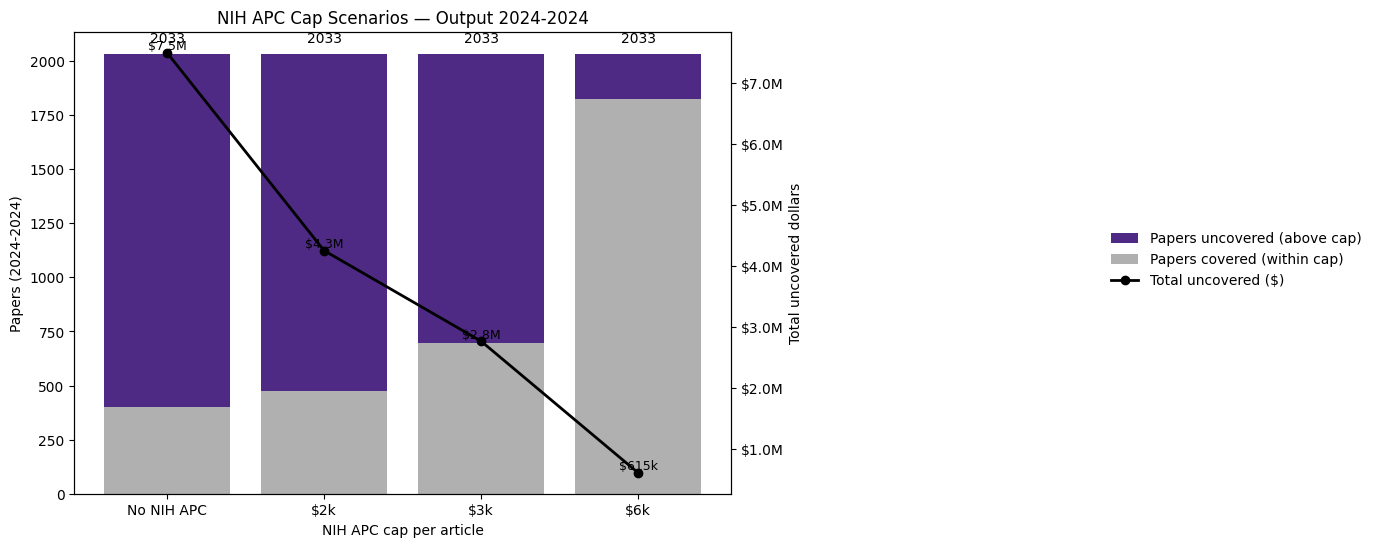

Saved chart -> scenario_overview_2024.png


In [6]:
## Run the code to create the chart


plot_scenario_overview_column(
    "2024/all_scenarios_summary.csv",
    outfile="scenario_overview_2024.png"
)

# # Single year (e.g., 2024)
# plot_scenario_overview_column(
#     "2024/all_scenarios_summary.csv",
#     outfile="scenario_overview_2024.png",
#     y_axis_label="Papers (2024)",               # optional override
#     legend_anchor=(1.18, 0.5),                  # push legend farther right if needed
#     right_margin=0.72                           # reserve more/less space for legend
